In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#라이브러리

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00


In [3]:
import cv2, glob, tqdm, json, time, os, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import concurrent.futures

from timm.models.layers import drop_path, to_2tuple, trunc_normal_
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 경로, 데이터셋 로드

In [4]:
root_path = '/content/drive/MyDrive/fitness'
copy_path = '/content'

In [5]:


palette = [(255, 165, 0),(0, 128, 0),(128, 0, 128),(255, 0, 255),(0, 0, 128),(128, 128, 0),(0, 0, 255),(165, 42, 42),(0, 255, 255),(255, 192, 203),(70, 130, 90),(255, 99, 71),(0, 128, 128),(255, 0, 0),(0, 255, 0),(0, 0, 0),(255, 255, 255),(128, 128, 128),(210, 105, 30),(218, 165, 32),(173, 216, 230),(255, 20, 147),(0, 255, 127),(220, 20, 60)]
point_name = ['Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear', 'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow', 'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip', 'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle', 'Neck', 'Left Palm', 'Right Palm', 'Back', 'Waist', 'Left Foot', 'Right Foot']
linked_name =  [["Left Ear","Left Eye"],["Left Eye","Nose"],["Right Ear","Right Eye"],["Right Eye","Nose"],["Nose","Neck"],["Left Palm","Left Wrist"],["Left Wrist","Left Elbow"],["Left Elbow","Left Shoulder"],["Left Shoulder","Neck"],["Right Palm","Right Wrist"],["Right Wrist","Right Elbow"],["Right Elbow","Right Shoulder"],["Right Shoulder","Neck"],["Neck","Back"],["Back","Waist"],["Left Foot","Left Ankle"],["Left Ankle","Left Knee"],["Left Knee","Left Hip"],["Left Hip","Waist"],["Right Foot","Right Ankle"],["Right Ankle","Right Knee"],["Right Knee","Right Hip"],["Right Hip","Waist"]]

for i in range(len(linked_name)):
    linked_name[i][0] = point_name.index(linked_name[i][0])
    linked_name[i][1] = point_name.index(linked_name[i][1])

In [6]:
anomaly = {}
for model_num in range(5):
    with open(f'/content/drive/MyDrive/fitness/dataset/anomaly/{model_num}.json','r') as f:
        a = json.load(f)
        anomaly.update(a[f'{model_num}'])

In [7]:
dataset = [[],[],[],[],[]]

worker = 64
def load_file(filename):
    with open(filename) as f:
        label_json = json.load(f)
        for view in range(5):
            if len(label_json['frames']) != 0 :
                path_parts = filename.split("/")
                cropped_path = ("/".join(path_parts[:filename.count('/')-1])).replace("label","video")
                minx=1920
                miny=1080
                maxx=0
                maxy=0


                video_path = os.path.dirname(cropped_path + '/' + label_json['frames'][0][f'view{view+1}']['img_key'])+'.avi'
                if anomaly.get(video_path) is None:
                    tmp = [video_path,[],[],label_json['type_info']['exercise'],label_json['type_info']['type'],label_json['type_info']['pose'],filename]
                    for frame in range(len(label_json['frames'])):
                        pts_list = []

                        # 좌표 추가
                        for p in point_name:
                            pts_list.append([label_json['frames'][frame][f'view{view+1}']['pts'][p]['x'],
                                            label_json['frames'][frame][f'view{view+1}']['pts'][p]['y']])
                            minx = min(minx,label_json['frames'][frame][f'view{view+1}']['pts'][p]['x'])
                            miny = min(miny,label_json['frames'][frame][f'view{view+1}']['pts'][p]['y'])
                            maxx = max(maxx,label_json['frames'][frame][f'view{view+1}']['pts'][p]['x'])
                            maxy = max(maxy,label_json['frames'][frame][f'view{view+1}']['pts'][p]['y'])


                        tmp[2].append(pts_list)

                    tmp[1] = [minx,miny,maxx,maxy]

                    dataset[view].append(tmp)




# for i in tqdm.tqdm(range(0,len(file_list[:]),worker)):
#     with concurrent.futures.ThreadPoolExecutor(max_workers=worker) as executor:
#         executor.map(load_file, file_list[i:i+worker])

if os.path.exists(f"{root_path}/dataset/PE.pkl"):
    with open(f"{root_path}/dataset/PE.pkl","rb") as f:
        dataset = pickle.load(f)
else:
    file_list = sorted(glob.glob(f"{root_path}/dataset/*/label/*/*[!d].json"))
    for i in tqdm.tqdm(range(0,len(file_list[:]),worker)):
        with concurrent.futures.ThreadPoolExecutor(max_workers=worker) as executor:
            executor.map(load_file, file_list[i:i+worker])
    with open(f"{root_path}/dataset/PE.pkl","wb") as f:
        pickle.dump(dataset, f)

for i in range(1,5):
    if len(dataset[i]) != len(dataset[i-1]) :
        print(i, "error")

dataset = [sorted(view) for view in dataset]

print()
print(len(dataset[0]))
print(dataset[0][0][0]) #path
print(dataset[0][0][1]) #min,max
print(dataset[0][0][2]) #frame
print(dataset[0][0][2][0]) #pts
print(dataset[0][0][3]) #exercise


KeyboardInterrupt: 

# 데이터셋 로컬에 복사

In [ ]:
def copy_tree(lst):
    filename = lst[0]
    shutil.copy(filename,filename.replace(root_path,copy_path))

# 데이터 경로 생성
for i in range(5):
    for j in range(len(dataset[i])):
        filename = dataset[i][j][0]
        from_dir = os.path.dirname(filename)+'/'
        to_dir = from_dir.replace(root_path,copy_path)
        if os.path.exists(to_dir)==False:
            os.makedirs(to_dir,exist_ok=True)

#데이터 로컬에 복사
for i in range(5):
    for j in tqdm.tqdm(range(0,len(dataset[i]),worker)):
        with concurrent.futures.ThreadPoolExecutor(max_workers=worker) as executor:
            executor.map(copy_tree, dataset[i][j:j+worker])

 66%|██████▌   | 372/567 [06:33<03:26,  1.06s/it]


KeyboardInterrupt: 

In [ ]:
#dataset 경로 변경
for i in range(5):
    for j in range(len(dataset[i])):
        dataset[i][j][0] = dataset[i][j][0].replace(root_path,copy_path)

#데이터셋 설정

In [8]:
train = []
valid = []
test = []
ratio = 0.2

'''for i, inner_list in enumerate(dataset):
    train += [inner_list[:-int(len(inner_list)*(ratio*2))]]
    valid += [inner_list[-int(len(inner_list)*(ratio*2)):-int(len(inner_list)*(ratio))] ]
    test += [inner_list[-int(len(inner_list)*(ratio)):] ]
'''
for i, inner_list in enumerate(dataset):
    train.append([data for j,data in enumerate(inner_list) if j % 5 != 0])
    valid.append([data for j,data in enumerate(inner_list) if j % 5 == 0])

for i in range(5):
    #print(i, len(train[i]),len(valid[i]),len(test[i]))
    print(i, len(train[i]),len(valid[i]))

0 0 0
1 0 0
2 0 0
3 0 0
4 0 0


In [9]:
valid_json = {}
for i in range(5):
    for j in range(len(valid[i])):
        valid_json[valid[i][j][0]] = 1

with open("/content/drive/MyDrive/fitness/dataset/validation.json",'w') as f:
    json.dump(valid_json,f)

In [10]:
train = []
valid = []
with open("/content/drive/MyDrive/fitness/dataset/validation.json",'r') as f:
    valid_json = json.load(f)
for i, inner_list in enumerate(dataset):
    train.append([data for j,data in enumerate(inner_list) if valid_json.get(data[0]) is None])
    valid.append([data for j,data in enumerate(inner_list) if valid_json.get(data[0]) is not None])


In [11]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 192

In [12]:


def draw_joint(img,pts,rad=3,line=1):
    out = img.copy()
    h,w,c = img.shape
    used = np.zeros_like(point_name,dtype=np.int32())

    if torch.max(pts) <=1:
        pts = pts * torch.tensor([w,h])

    for i,se in enumerate(linked_name):
        from_xy = (int(pts[se[0]][0]),int(pts[se[0]][1]))
        to_xy = (int(pts[se[1]][0]),int(pts[se[1]][1]))

        out = cv2.line(out,from_xy,to_xy,[255,255,255],line,cv2.LINE_AA)
        if (used[se[0]]==0):
            out= cv2.circle(out,from_xy,rad,palette[se[0]],-1,cv2.LINE_AA)
            used[se[0]] = 1

        if (used[se[1]]==0):
            out= cv2.circle(out,to_xy,rad,palette[se[1]],-1,cv2.LINE_AA)
            used[se[1]] = 1

    return out

def denormalization(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    out_img =  img * std  + mean
    return out_img

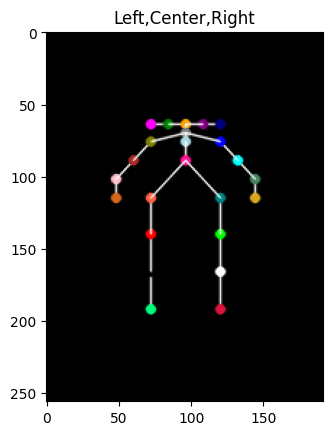

In [13]:
# 뒤에서 본 신체의 좌표
body_coordinates = [[0.5, 0.25], [0.4375, 0.25], [0.5625, 0.25], [0.375, 0.25], [0.625, 0.25], [0.375, 0.3], [0.625, 0.3], [0.3125, 0.35], [0.6875, 0.35], [0.25, 0.4], [0.75, 0.4], [0.375, 0.45], [0.625, 0.45], [0.375, 0.55], [0.625, 0.55], [0.375, 0.65], [0.625, 0.65], [0.5, 0.275], [0.25, 0.45], [0.75, 0.45], [0.5, 0.3], [0.5, 0.35], [0.375, 0.75], [0.625, 0.75]]
body_coord_visualization = draw_joint(np.zeros((256,192,3)).astype(np.uint8()),torch.tensor(body_coordinates))
img = np.zeros((256,192,3),dtype = np.uint8())
plt.title("Left,Center,Right")
plt.imshow(body_coord_visualization)
plt.show()


In [14]:
class fitness(Dataset):
    def __init__(self, data, views = [2, 3, 4], training = True, frame_mode=1): # ,frame_mode=0 0번프레임만 1 랜덤 2 전체

        self.data = data

        self.views = [view-1 for view in views]

        self.training = training
        self.frame_mode = frame_mode

        self.len_data = 0
        self.idx_list = []
        for view in self.views:
            for idx in range(len(self.data[view])):
                if (self.frame_mode<=1):
                    self.idx_list.append([view,idx,-1])
                    self.len_data += 1
                else:
                    for frame in range(len(self.data[view][idx][2])):
                        self.idx_list.append([view,idx,frame])
                        self.len_data += 1

        if training :
            transform_list = [
                A.ColorJitter(p=0.5),
                #A.HorizontalFlip(p=0.5),
                A.Affine(mode=0),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ]
        else :
            transform_list = [A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ToTensorV2()]

        self.transforms = A.Compose(transform_list, keypoint_params=A.KeypointParams(format='xy',remove_invisible=False))


    def __len__(self):
        return self.len_data

    def gaussian_heatmap(self, center,img_size = (224,224),sig=5):
        x_axis = np.linspace(0,img_size[0]-1,img_size[0])-center[0]
        y_axis = np.linspace(0,img_size[1]-1,img_size[1])-center[1]
        xx,yy = np.meshgrid(x_axis,y_axis)
        kernel = np.exp(-0.5*(np.square(xx)+np.square(yy))/np.square(sig))
        return kernel #좌표 오버나면 알아서 없애줌

    def __getitem__(self, idx):

        view_idx, data_idx, frame_idx = self.idx_list[idx]

        if self.frame_mode==0:
            frame_idx = 0
        elif self.frame_mode==1:
            frame_idx = np.random.randint(0,len(self.data[view_idx][data_idx][2]))

        x1,y1,x2,y2 = self.data[view_idx][data_idx][1]

        #사전에 미리 Crop한 이미지 x1,y1,x2,y2
        crop_min_x = max(0,x1-200)
        crop_min_y = max(0,y1-200)
        crop_max_x = min(1920,x2+200)
        crop_max_y = min(1080,y2+200)

        path = self.data[view_idx][data_idx][0]

        if (os.path.exists(path)==False):
            print(path,"가 없습니다.")


        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx*2) # 프레임 시작위치를 idx 프레임으로 옮김
        ret, img = cap.read()
        cap.release()

        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))

        coord = np.array(self.data[view_idx][data_idx][2][frame_idx]) - [crop_min_x,crop_min_y]

        coord = coord * [IMAGE_WIDTH/(crop_max_x-crop_min_x),IMAGE_HEIGHT/(crop_max_y-crop_min_y)]

        transformed = self.transforms(image=img,keypoints=coord)
        img = transformed['image']
        coord = transformed['keypoints']

        heatmap = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,24),dtype= np.float32)



        for i in range(24):
            heatmap[:,:,i] = self.gaussian_heatmap((np.round(coord[i][0],0),np.round(coord[i][1],0)),(IMAGE_WIDTH,IMAGE_HEIGHT))

        coord = torch.tensor(coord,dtype=torch.float32) / torch.tensor([IMAGE_WIDTH,IMAGE_HEIGHT])

        heatmap = cv2.resize(heatmap,(IMAGE_WIDTH//4,IMAGE_HEIGHT//4))
        heatmap = torch.from_numpy(heatmap)
        heatmap = torch.permute(heatmap,(2,0,1))

        dataset = {"idx" : [view_idx, data_idx, frame_idx],
                   "image" : img,
                   "coord" : coord,
                   "heatmap" : heatmap,
                   "view" : view_idx,
                   "class" : self.data[view_idx][data_idx][3],
                   "type" : self.data[view_idx][data_idx][4],
                   "pose" : self.data[view_idx][data_idx][5],
                   "label_path" : self.data[view_idx][data_idx][6]}


        return dataset



In [15]:

train_set = fitness(train, views = [1,2,3,4,5])
valid_set = fitness(valid, views = [1,2,3,4,5], training =  False, frame_mode=0)
#test_set = fitness(test, views = [1,2,3,4,5], training =  False, frame_mode=0)
#print(len(train_set), len(valid_set), len(test_set))
print(len(train_set), len(valid_set))

0 0


In [16]:


for i in range(10):
    start_time = time.time()
    data = train_set[i]
    print(time.time()-start_time)


    img = (denormalization(np.transpose(data["image"],(1,2,0)).numpy())*255).astype(np.uint8())
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(draw_joint(img,data["coord"]))
    plt.subplot(1,3,3)
    plt.imshow(torch.sum(data["heatmap"],0))
    plt.show()


IndexError: list index out of range

#모델


## ViTPose

### backbone

In [17]:
def get_abs_pos(abs_pos, h, w, ori_h, ori_w, has_cls_token=True):
    """
    Calculate absolute positional embeddings. If needed, resize embeddings and remove cls_token
        dimension for the original embeddings.
    Args:
        abs_pos (Tensor): absolute positional embeddings with (1, num_position, C).
        has_cls_token (bool): If true, has 1 embedding in abs_pos for cls token.
        hw (Tuple): size of input image tokens.

    Returns:
        Absolute positional embeddings after processing with shape (1, H, W, C)
    """
    cls_token = None
    B, L, C = abs_pos.shape
    if has_cls_token:
        cls_token = abs_pos[:, 0:1]
        abs_pos = abs_pos[:, 1:]

    if ori_h != h or ori_w != w:
        new_abs_pos = F.interpolate(
            abs_pos.reshape(1, ori_h, ori_w, -1).permute(0, 3, 1, 2),
            size=(h, w),
            mode="bicubic",
            align_corners=False,
        ).permute(0, 2, 3, 1).reshape(B, -1, C)

    else:
        new_abs_pos = abs_pos

    if cls_token is not None:
        new_abs_pos = torch.cat([cls_token, new_abs_pos], dim=1)
    return new_abs_pos

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

    def extra_repr(self):
        return 'p={}'.format(self.drop_prob)

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., attn_head_dim=None,):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.dim = dim

        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads

        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm, attn_head_dim=None
                 ):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, attn_head_dim=attn_head_dim
            )

        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, ratio=1):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) * (ratio ** 2)
        self.patch_shape = (int(img_size[0] // patch_size[0] * ratio), int(img_size[1] // patch_size[1] * ratio))
        self.origin_patch_shape = (int(img_size[0] // patch_size[0]), int(img_size[1] // patch_size[1]))
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=(patch_size[0] // ratio), padding=4 + 2 * (ratio//2-1))

    def forward(self, x, **kwargs):
        B, C, H, W = x.shape
        x = self.proj(x)
        Hp, Wp = x.shape[2], x.shape[3]

        x = x.flatten(2).transpose(1, 2) # B,C,H,W -> B,C,H*W -> B,H*W,C
        return x, (Hp, Wp)


class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """
    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x

class ViT(nn.Module):

    def __init__(self,
                 img_size=224, patch_size=16, in_chans=3, num_classes=80, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=None, use_checkpoint=False,
                 frozen_stages=-1, ratio=1, last_norm=True,
                 patch_padding='pad', freeze_attn=False, freeze_ffn=False,
                 ):
        # Protect mutable default arguments
        super(ViT, self).__init__()
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.frozen_stages = frozen_stages
        self.use_checkpoint = use_checkpoint
        self.patch_padding = patch_padding
        self.freeze_attn = freeze_attn
        self.freeze_ffn = freeze_ffn
        self.depth = depth
        self.view_embedding = nn.Embedding(5,embed_dim)

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, ratio=ratio)
        num_patches = self.patch_embed.num_patches

        # since the pretraining model has class token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                )
            for i in range(depth)])

        self.last_norm = norm_layer(embed_dim) if last_norm else nn.Identity()

        if self.pos_embed is not None:
            trunc_normal_(self.pos_embed, std=.02)

        self._freeze_stages()

    def _freeze_stages(self):
        """Freeze parameters."""
        if self.frozen_stages >= 0:
            self.patch_embed.eval()
            for param in self.patch_embed.parameters():
                param.requires_grad = False

        for i in range(1, self.frozen_stages + 1):
            m = self.blocks[i]
            m.eval()
            for param in m.parameters():
                param.requires_grad = False

        if self.freeze_attn:
            for i in range(0, self.depth):
                m = self.blocks[i]
                m.attn.eval()
                m.norm1.eval()
                for param in m.attn.parameters():
                    param.requires_grad = False
                for param in m.norm1.parameters():
                    param.requires_grad = False

        if self.freeze_ffn:
            self.pos_embed.requires_grad = False
            self.patch_embed.eval()
            for param in self.patch_embed.parameters():
                param.requires_grad = False
            for i in range(0, self.depth):
                m = self.blocks[i]
                m.mlp.eval()
                m.norm2.eval()
                for param in m.mlp.parameters():
                    param.requires_grad = False
                for param in m.norm2.parameters():
                    param.requires_grad = False

    def init_weights(self, pretrained=None):
        """Initialize the weights in backbone.
        Args:
            pretrained (str, optional): Path to pre-trained weights.
                Defaults to None.
        """
        super().init_weights(pretrained, patch_padding=self.patch_padding)

        if pretrained is None:
            def _init_weights(m):
                if isinstance(m, nn.Linear):
                    trunc_normal_(m.weight, std=.02)
                    if isinstance(m, nn.Linear) and m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.LayerNorm):
                    nn.init.constant_(m.bias, 0)
                    nn.init.constant_(m.weight, 1.0)

            self.apply(_init_weights)

    def get_num_layers(self):
        return len(self.blocks)

    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward_features(self, x, view):
        B, C, H, W = x.shape
        x, (Hp, Wp) = self.patch_embed(x) #B,H*W,C




        if self.pos_embed is not None:
            # fit for multiple GPU training
            # since the first element for pos embed (sin-cos manner) is zero, it will cause no difference
            # pos_embed[:,0]는 둘다 0이기 때문에 0을 더해도 동일한 값이기에 상관 없음
            # cls_token은 아마 0번 인덱스에 들어간 듯
            if view is not None:
                emb_view = self.view_embedding(view).view(B,1,-1) #B,1,C
                x = torch.cat([emb_view,x],1) # B,H*W+1,C
                x = x + self.pos_embed
            else:
                x = x + self.pos_embed[:, 1:] + self.pos_embed[:, :1]

        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)

        x = self.last_norm(x)

        if view is not None:
            cls = x[:,0]
            xp = x[:,1:].permute(0, 2, 1).reshape(B, -1, Hp, Wp).contiguous()
            return xp, cls
        else:
            xp = x.permute(0, 2, 1).reshape(B, -1, Hp, Wp).contiguous()
            return xp, None

    def forward(self, x, view=None):
        x = self.forward_features(x,view)
        return x

def ViT_b():
    return ViT(img_size=(256, 192),
                patch_size=16,
                embed_dim=768,
                depth=12,
                num_heads=12,
                ratio=1,
                mlp_ratio=4,
                qkv_bias=True,
                drop_path_rate=0.3
            )

def ViT_l():
    return ViT(img_size=(256, 192),
                patch_size=16,
                embed_dim=1024,
                depth=24,
                num_heads=16,
                ratio=1,
                mlp_ratio=4,
                qkv_bias=True,
                drop_path_rate=0.5
            )

### 모델 전체


In [18]:
class ViTpose(nn.Module):
    def __init__(self,backbone='b',mode = "heatmap"):
        super(ViTpose,self).__init__()
        if backbone == 'b':
            self.backbone = ViT_b()
            self.out_channels = 768
        elif backbone == 'l':
            self.backbone = ViT_l()
            self.out_channels = 1024

        self.view = nn.Linear(self.out_channels,5)


        self.mode = mode
        if self.mode == "heatmap" :
            self.head = nn.Sequential(
                nn.ReLU(),
                nn.Upsample(scale_factor=4,mode='bilinear'),
                nn.Conv2d(self.out_channels,len(point_name),3,1,1)
            )
        elif self.mode == "both":
            def group_conv(i,o,k,s,p,g,n):

                layers = []

                layers.append(nn.Conv2d(i,o,k,s,p,groups=g))
                layers.append(nn.ReLU())

                for i in range(n-1):
                    layers.append(nn.Conv2d(o,o,k,s,p,groups=g))
                    layers.append(nn.ReLU())
                return nn.Sequential(*layers)

            def offset_block(in_channels,n):
                layers = []
                for i in range(n):
                    layers.append(group_conv(in_channels*(2**i),in_channels*(2**(i+1)),3,1,1,g=len(point_name),n=2))
                    layers.append(nn.MaxPool2d(2,2))
                return nn.Sequential(*layers)

            self.head = nn.Sequential(
                nn.ReLU(),
                nn.Upsample(scale_factor=4,mode='bilinear'),
                nn.Conv2d(self.out_channels,len(point_name),3,1,1)
            )

            #Method2,3
            self.offset_head = nn.Sequential(
                offset_block(len(point_name),4),
                nn.Conv2d(len(point_name)*(2**4),len(point_name)*2,(4,3),1,groups=len(point_name))
            )
        else :
            self.pool = nn.AdaptiveAvgPool2d(1)
            self.head = nn.Sequential(
                nn.ReLU(),
                nn.Linear(self.out_channels,len(point_name)*2)
            )



    def forward(self,x,view=None):

        b,_,_,_ = x.shape

        out = {}
        xp,cls = self.backbone(x,view)
        out['feature'] = xp

        if cls is not None:
            out['view'] = self.view(cls)

        if self.mode == "heatmap":
            out['heatmap'] = self.head(out['feature'])
        elif self.mode == "both":
            out['heatmap'] = self.head(out['feature'])

            with torch.no_grad():
                bridge = torch.zeros_like(out['heatmap'])
                bridge.set_(out['heatmap'])

            #Method 2,3
            out['coord'] = self.offset_head(bridge).view(b,-1,2)
        else :
            out['coord'] = self.pool(out['feature']).view(b,-1)
            out['coord'] = self.head(out['coord']).view(b,-1,2)

        return out

## ResPose

In [19]:
BN_MOMENTUM = 0.1

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                                  momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck_CAFFE(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_CAFFE, self).__init__()
        # add stride to conv1x1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                                  momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class PoseResNet(nn.Module):

    def __init__(self, block, layers, cfg, **kwargs):
        self.inplanes = 64
        extra = cfg.MODEL.EXTRA
        self.deconv_with_bias = extra.DECONV_WITH_BIAS

        super(PoseResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # used for deconv layers
        self.deconv_layers = self._make_deconv_layer(
            extra.NUM_DECONV_LAYERS,
            extra.NUM_DECONV_FILTERS,
            extra.NUM_DECONV_KERNELS,
        )

        self.final_layer = nn.Conv2d(
            in_channels=extra.NUM_DECONV_FILTERS[-1],
            out_channels=cfg.MODEL.NUM_JOINTS,
            kernel_size=extra.FINAL_CONV_KERNEL,
            stride=1,
            padding=1 if extra.FINAL_CONV_KERNEL == 3 else 0
        )

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _get_deconv_cfg(self, deconv_kernel, index):
        if deconv_kernel == 4:
            padding = 1
            output_padding = 0
        elif deconv_kernel == 3:
            padding = 1
            output_padding = 1
        elif deconv_kernel == 2:
            padding = 0
            output_padding = 0

        return deconv_kernel, padding, output_padding

    def _make_deconv_layer(self, num_layers, num_filters, num_kernels):
        assert num_layers == len(num_filters), \
            'ERROR: num_deconv_layers is different len(num_deconv_filters)'
        assert num_layers == len(num_kernels), \
            'ERROR: num_deconv_layers is different len(num_deconv_filters)'

        layers = []
        for i in range(num_layers):
            kernel, padding, output_padding = \
                self._get_deconv_cfg(num_kernels[i], i)

            planes = num_filters[i]
            layers.append(
                nn.ConvTranspose2d(
                    in_channels=self.inplanes,
                    out_channels=planes,
                    kernel_size=kernel,
                    stride=2,
                    padding=padding,
                    output_padding=output_padding,
                    bias=self.deconv_with_bias))
            layers.append(nn.BatchNorm2d(planes, momentum=BN_MOMENTUM))
            layers.append(nn.ReLU(inplace=True))
            self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.deconv_layers(x)
        x = self.final_layer(x)

        return x

    def init_weights(self, pretrained=''):
        if os.path.isfile(pretrained):
            for name, m in self.deconv_layers.named_modules():
                if isinstance(m, nn.ConvTranspose2d):
                    nn.init.normal_(m.weight, std=0.001)
                    if self.deconv_with_bias:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
            for m in self.final_layer.modules():
                if isinstance(m, nn.Conv2d):
                    # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                    nn.init.normal_(m.weight, std=0.001)
                    nn.init.constant_(m.bias, 0)

            # pretrained_state_dict = torch.load(pretrained)
            # self.load_state_dict(pretrained_state_dict, strict=False)
            checkpoint = torch.load(pretrained)
            if isinstance(checkpoint, OrderedDict):
                state_dict = checkpoint
            elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
                state_dict_old = checkpoint['state_dict']
                state_dict = OrderedDict()
                # delete 'module.' because it is saved from DataParallel module
                for key in state_dict_old.keys():
                    if key.startswith('module.'):
                        # state_dict[key[7:]] = state_dict[key]
                        # state_dict.pop(key)
                        state_dict[key[7:]] = state_dict_old[key]
                    else:
                        state_dict[key] = state_dict_old[key]
            else:
                raise RuntimeError(
                    'No state_dict found in checkpoint file {}'.format(pretrained))
            self.load_state_dict(state_dict, strict=False)
        else:
            raise ValueError('imagenet pretrained model does not exist')


resnet_spec = {18: (BasicBlock, [2, 2, 2, 2]),
               34: (BasicBlock, [3, 4, 6, 3]),
               50: (Bottleneck, [3, 4, 6, 3]),
               101: (Bottleneck, [3, 4, 23, 3]),
               152: (Bottleneck, [3, 8, 36, 3])}


def get_pose_net(cfg, is_train, **kwargs):
    num_layers = cfg.MODEL.EXTRA.NUM_LAYERS
    style = cfg.MODEL.STYLE

    block_class, layers = resnet_spec[num_layers]

    if style == 'caffe':
        block_class = Bottleneck_CAFFE

    model = PoseResNet(block_class, layers, cfg, **kwargs)

    if is_train and cfg.MODEL.INIT_WEIGHTS:
        model.init_weights(cfg.MODEL.PRETRAINED)

    return model

#학습

In [ ]:
def MPJPE_heatmap(pred,true,image_size=[IMAGE_WIDTH,IMAGE_HEIGHT],mean=True): #Mean Per Joint Position Error ( 낮은게 좋음 )
    with torch.no_grad():
        b,c,h,w = pred.shape

        pred = pred.reshape(b,c,h*w)

        pred_flatten_idx = torch.argmax(pred,-1).reshape(b,c,1) # heatmap에서 제일 큰 값이 있는 index
        pred_xy = torch.cat([pred_flatten_idx%w/w,pred_flatten_idx//w/h],-1) # b, 24, 2 [x,y]

        wh = torch.tensor(image_size,dtype=torch.float32).to(device)

        metric = torch.mean(torch.sqrt(torch.sum(((pred_xy-true)*wh)**2,-1)+1e-5),1)

        if mean:
            metric = torch.mean(metric)



    return metric

def MPJPE_coord(pred,true,image_size=[IMAGE_WIDTH,IMAGE_HEIGHT],mean= True): #Mean Per Joint Position Error ( 낮은게 좋음 )
    with torch.no_grad():
        b,j,c = pred.shape

        wh = torch.tensor(image_size,dtype=torch.float32).to(device)

        metric = torch.mean(torch.sqrt(torch.sum(((pred-true)* wh)**2,-1)+1e-5),1)
        if mean:
            metric = torch.mean(metric)

    return metric

In [ ]:
def seed_everything(seed = 32):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(32)

In [ ]:
if "model" in globals():
    model.cpu()
    torch.cuda.empty_cache()

decoder = 'heatmap'

model_input = ["image","view"]

if (decoder == 'heatmap'):
    metrics = {"heatmap":[MPJPE_heatmap,"heatmap","coord"]} # [평가지표, Pred, Label]
    criterions = {"heatmap":nn.MSELoss(),
                  "view":nn.CrossEntropyLoss()}

elif (decoder == 'both'):
    metrics = {"heatmap":[MPJPE_heatmap,"heatmap","coord"],
              "coord":MPJPE_coord}
    criterions = {"heatmap":nn.MSELoss(),
                 "coord":nn.MSELoss()}
else:
    metrics = {"coord":MPJPE_coord}
    criterions = {"coord":nn.MSELoss()}


model = ViTpose(backbone = 'b', mode = decoder)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/fitness/pretrain/pose/vitpose-b-simple.pth')['state_dict'],strict=False)

learning_status = {
    'train_metrics' : [],
    'valid_metrics' : [],
    'train_losses' : [],
    'valid_losses' : [],
    'lrs' : [],
    'best' : []
}
min_epoch = 0

optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': 1e-4},
    {'params': model.head.parameters(), 'lr': 5e-4},
    {'params': model.view.parameters(), 'lr': 5e-4},], weight_decay=0.01)
    #{'params': model.offset_head.parameters(), 'lr': 5e-4}], weight_decay=0.01)

warmup_epochs = 5
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,last_epoch=len(learning_status['lrs'])-1, lr_lambda=lambda epoch: epoch / warmup_epochs)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=False, num_workers=16)

In [ ]:
model_save_path = root_path + f'/model/PE/ViTPose_base_simple({decoder})[model1,no_anomaly]/'

model = model.to(device)

epochs = 10


In [ ]:

def train_begin(training,loader,running_loss,running_metric):
    if training :
        desc = "Train"
    else:
        desc = "Valid"

    progress = tqdm.tqdm(loader,desc=f'Epoch:{epoch+1}/{epochs}')
    for i,data in enumerate(progress):


        if (training):
            optimizer.zero_grad()

        pred = model(*[data[key].to(device) for key in model_input])

        total_loss = torch.tensor(0.0).to(device)
        metric = torch.tensor(0.0).to(device)

        loss_list = []
        metric_list = []


        for key in criterions.keys():
            if (type(criterions[key]) == list):
                loss = criterions[key][0](pred[criterions[key][1]],data[criterions[key][2]].to(device))
            else :
                loss = criterions[key](pred[key],data[key].to(device))
            total_loss  = total_loss+loss
            loss_list.append(loss.detach().cpu().numpy())

        for key in metrics.keys():
            if (type(metrics[key]) == list):
                metric = metrics[key][0](pred[metrics[key][1]],data[metrics[key][2]].to(device))
            else :
                metric = metrics[key](pred[key],data[key].to(device))
            metric_list.append(metric.cpu())

        if (training):

            total_loss.backward()

            optimizer.step()

        running_loss += loss_list
        running_metric += metric_list

        progress.set_description(f'Epoch:{epoch+1}/{epochs} | {desc}_Metric{list(metrics.keys())}:{np.round(running_metric/(i+1),5)} | {desc}_Loss{list(criterions.keys())}:{np.round(running_loss/(i+1),5)}')

In [ ]:


print("모델 저장 경로 : "+ model_save_path)
fit_time = time.time()
start_epoch = len(learning_status['lrs'])



for epoch in range(start_epoch,epochs):
    print("모델명 :", model_save_path.split('/')[-2])

    #Warmup Schedule
    if epoch < warmup_epochs :
        scheduler.step()
        print("lr이 변경되었습니다.",optimizer.param_groups[0]['lr'])


    running_train_loss = np.zeros((len(criterions.keys())))
    running_valid_loss = np.zeros((len(criterions.keys())))

    running_train_metric = np.zeros((len(metrics.keys())))
    running_valid_metric = np.zeros((len(metrics.keys())))


    model.train()
    train_begin(True,train_loader,running_train_loss,running_train_metric)
    model.eval()
    with torch.no_grad():
        train_begin(False,valid_loader,running_valid_loss,running_valid_metric)


    learning_status['train_losses'].append((running_train_loss/len(train_loader)))
    learning_status['valid_losses'].append((running_valid_loss/len(valid_loader)))
    learning_status['train_metrics'].append((running_train_metric/len(train_loader)))
    learning_status['valid_metrics'].append((running_valid_metric/len(valid_loader)))
    learning_status['lrs'].append(optimizer.param_groups[0]['lr'])

    checkpoint = {
        'epoch': epoch+1 , #에폭
        'model': model.state_dict(),  # 모델
        'optimizer': optimizer.state_dict(),  # 옵티마이저
        'scheduler': scheduler.state_dict()  # 스케줄러
    }
    if os.path.exists(model_save_path) == False:
        os.makedirs(model_save_path,exist_ok=True)


    if sum(learning_status['valid_losses'][min_epoch]) >= sum(learning_status['valid_losses'][-1]) and sum(learning_status['valid_losses'][-1] > 0):
        print(f"Valid Loss가 최소가 됐습니다. ({sum(learning_status['valid_losses'][min_epoch]):.5f}({min_epoch+1}) -> {sum(learning_status['valid_losses'][-1]):.5f}({len(learning_status['valid_losses'])}))")
        print(f'해당 모델이 {model_save_path}Best{epoch+1}.pth 경로에 저장됩니다.')
        min_epoch = len(learning_status['valid_losses'])-1
        torch.save(checkpoint, model_save_path+f'Best{epoch+1}.pth')
        learning_status['best'].append(sum(learning_status['valid_losses'][-1]))
    else:
        print(f"Valid_Loss가 최소가 되지 못했습니다.(최소 Epoch:{min_epoch+1} : {sum(learning_status['valid_losses'][min_epoch]):.5f}, 현재 : {sum(learning_status['valid_losses'][-1]):.5f})")
        learning_status['best'].append('False')

    torch.save(checkpoint, model_save_path+f'Last{epoch+1}.pth')

    df = pd.DataFrame(learning_status)
    df.to_csv(model_save_path+'status.csv', index=True)

    print('')


print('학습 최종 시간: {:.2f} 분\n' .format((time.time()- fit_time)/60))

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


모델 저장 경로 : /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/
모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]
lr이 변경되었습니다. 2e-05


Epoch:1/10 | Train_Metric['heatmap']:[6.85446] | Train_Loss['heatmap', 'view']:[0.00059 0.00563]: 100%|██████████| 9061/9061 [1:27:18<00:00,  1.73it/s]
Epoch:1/10 | Valid_Metric['heatmap']:[4.82108] | Valid_Loss['heatmap', 'view']:[3.9e-04 1.0e-05]: 100%|██████████| 2266/2266 [08:48<00:00,  4.29it/s]


Valid Loss가 최소가 됐습니다. (0.00039(1) -> 0.00039(1))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best1.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]
lr이 변경되었습니다. 4e-05


Epoch:2/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:2/10 | Train_Metric['heatmap']:[4.84376] | Train_Loss['heatmap', 'view']:[0.0004 0.    ]: 100%|██████████| 9061/9061 [1:27:05<00:00,  1.73it/s]
Epoch:2/10 | Valid_Metric['heatmap']:[4.30636] | Valid_Loss['heatmap', 'view']:[0.00031 0.     ]: 100%|██████████| 2266/2266 [08:57<00:00,  4.22it/s]


Valid Loss가 최소가 됐습니다. (0.00039(1) -> 0.00031(2))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best2.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]
lr이 변경되었습니다. 6e-05


Epoch:3/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:3/10 | Train_Metric['heatmap']:[4.53413] | Train_Loss['heatmap', 'view']:[0.00035 0.     ]: 100%|██████████| 9061/9061 [1:27:07<00:00,  1.73it/s]
Epoch:3/10 | Valid_Metric['heatmap']:[4.08835] | Valid_Loss['heatmap', 'view']:[0.00029 0.     ]: 100%|██████████| 2266/2266 [08:56<00:00,  4.22it/s]


Valid Loss가 최소가 됐습니다. (0.00031(2) -> 0.00029(3))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best3.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]
lr이 변경되었습니다. 8e-05


Epoch:4/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:4/10 | Train_Metric['heatmap']:[4.40955] | Train_Loss['heatmap', 'view']:[0.00033 0.     ]: 100%|██████████| 9061/9061 [1:27:07<00:00,  1.73it/s]
Epoch:4/10 | Valid_Metric['heatmap']:[4.02192] | Valid_Loss['heatmap', 'view']:[0.00027 0.     ]: 100%|██████████| 2266/2266 [08:49<00:00,  4.28it/s]


Valid Loss가 최소가 됐습니다. (0.00029(3) -> 0.00027(4))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best4.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]
lr이 변경되었습니다. 0.0001


Epoch:5/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:5/10 | Train_Metric['heatmap']:[4.34365] | Train_Loss['heatmap', 'view']:[0.00032 0.     ]: 100%|██████████| 9061/9061 [1:27:05<00:00,  1.73it/s]
Epoch:5/10 | Valid_Metric['heatmap']:[3.97728] | Valid_Loss['heatmap', 'view']:[0.00027 0.     ]: 100%|██████████| 2266/2266 [08:51<00:00,  4.27it/s]


Valid Loss가 최소가 됐습니다. (0.00027(4) -> 0.00027(5))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best5.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]


Epoch:6/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:6/10 | Train_Metric['heatmap']:[4.24684] | Train_Loss['heatmap', 'view']:[0.00031 0.     ]: 100%|██████████| 9061/9061 [1:27:03<00:00,  1.73it/s]
Epoch:6/10 | Valid_Metric['heatmap']:[3.87365] | Valid_Loss['heatmap', 'view']:[0.00026 0.     ]: 100%|██████████| 2266/2266 [08:50<00:00,  4.27it/s]


Valid Loss가 최소가 됐습니다. (0.00027(5) -> 0.00026(6))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best6.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]


Epoch:7/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:7/10 | Train_Metric['heatmap']:[4.17431] | Train_Loss['heatmap', 'view']:[0.0003 0.    ]: 100%|██████████| 9061/9061 [1:27:08<00:00,  1.73it/s]
Epoch:7/10 | Valid_Metric['heatmap']:[3.88345] | Valid_Loss['heatmap', 'view']:[0.00025 0.     ]: 100%|██████████| 2266/2266 [08:50<00:00,  4.27it/s]


Valid Loss가 최소가 됐습니다. (0.00026(6) -> 0.00025(7))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best7.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]


Epoch:8/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:8/10 | Train_Metric['heatmap']:[4.12117] | Train_Loss['heatmap', 'view']:[0.00029 0.     ]: 100%|██████████| 9061/9061 [1:27:04<00:00,  1.73it/s]
Epoch:8/10 | Valid_Metric['heatmap']:[3.84206] | Valid_Loss['heatmap', 'view']:[0.00025 0.     ]: 100%|██████████| 2266/2266 [08:56<00:00,  4.23it/s]


Valid Loss가 최소가 됐습니다. (0.00025(7) -> 0.00025(8))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best8.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]


Epoch:9/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:9/10 | Train_Metric['heatmap']:[4.08248] | Train_Loss['heatmap', 'view']:[0.00029 0.     ]: 100%|██████████| 9061/9061 [1:27:06<00:00,  1.73it/s]
Epoch:9/10 | Valid_Metric['heatmap']:[3.798] | Valid_Loss['heatmap', 'view']:[0.00024 0.     ]: 100%|██████████| 2266/2266 [08:53<00:00,  4.25it/s]


Valid Loss가 최소가 됐습니다. (0.00025(8) -> 0.00024(9))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best9.pth 경로에 저장됩니다.

모델명 : ViTPose_base_simple(heatmap)[model1,no_anomaly]


Epoch:10/10:   0%|          | 0/9061 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:10/10 | Train_Metric['heatmap']:[4.03139] | Train_Loss['heatmap', 'view']:[0.00028 0.     ]: 100%|██████████| 9061/9061 [1:27:02<00:00,  1.73it/s]
Epoch:10/10 | Valid_Metric['heatmap']:[3.78661] | Valid_Loss['heatmap', 'view']:[0.00024 0.     ]: 100%|██████████| 2266/2266 [09:01<00:00,  4.18it/s]


Valid Loss가 최소가 됐습니다. (0.00024(9) -> 0.00024(10))
해당 모델이 /content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best10.pth 경로에 저장됩니다.

학습 최종 시간: 961.36 분



# 이전 학습 상황 불러오기

In [ ]:
f"\'/model/{model_save_path.split('/')[-2]}/\'"

In [ ]:
torch.cuda.empty_cache()
model_load_path = root_path + '/model/ViTPose_large_simple(coord)/'

learning_status = pd.read_csv(model_load_path+f'status.csv',index_col=0).to_dict(orient='list')
checkpoint = torch.load(model_load_path+f'Last.pth','cuda')
model.to(device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

for k in learning_status.keys():
    for i in range(len(learning_status[k])):
        if k!='lrs':
            learning_status[k][i] = np.array([item for item in learning_status[k][i][1:-1].split(' ') if item != ''],dtype=np.float32)



learning_status = {
    'train_mpjpes': learning_status['train_mpjpes'][:checkpoint['epoch']],
    'valid_mpjpes': learning_status['valid_mpjpes'][:checkpoint['epoch']],
    'train_losses': learning_status['train_losses'][:checkpoint['epoch']],
    'valid_losses': learning_status['valid_losses'][:checkpoint['epoch']],
    'lrs': learning_status['lrs'][:checkpoint['epoch']],
    'best' : learning_status['best'][:checkpoint['epoch']]
}

min_epoch = np.argmin(np.sum(learning_status['valid_losses'],-1))

for i in range(len(learning_status['valid_mpjpes'])):
    print(f"Epoch:{i+1} | Train_Acc : {np.round(learning_status['train_mpjpes'][i],4)} | Train_Loss : {np.round(learning_status['train_losses'][i],4)}")
    print(f"Epoch:{i+1} | Valid_Acc : {np.round(learning_status['valid_mpjpes'][i],4)} | Valid_Loss : {np.round(learning_status['valid_losses'][i],4)}")
    print()

print(len(learning_status['lrs']),min_epoch+1,learning_status['train_mpjpes'][-1],learning_status['train_losses'][-1],learning_status['valid_mpjpes'][-1],learning_status['valid_losses'][-1],learning_status['lrs'][-1])
print(len(learning_status['lrs']),min_epoch+1,learning_status['train_mpjpes'][min_epoch],learning_status['train_losses'][min_epoch],learning_status['valid_mpjpes'][min_epoch],learning_status['valid_losses'][min_epoch],learning_status['lrs'][min_epoch])

# 신경망 기반 이상치 탐지

In [ ]:
def MPJPE_heatmap(pred,true,image_size=[IMAGE_WIDTH,IMAGE_HEIGHT],mean=True): #Mean Per Joint Position Error ( 낮은게 좋음 )
    with torch.no_grad():
        b,c,h,w = pred.shape

        pred = pred.reshape(b,c,h*w)

        pred_flatten_idx = torch.argmax(pred,-1).reshape(b,c,1) # heatmap에서 제일 큰 값이 있는 index
        pred_xy = torch.cat([pred_flatten_idx%w/w,pred_flatten_idx//w/h],-1) # b, 24, 2 [x,y]

        wh = torch.tensor(image_size,dtype=torch.float32,device=pred.device)

        dist = torch.sqrt(torch.sum(((pred_xy-true)* wh)**2,-1)+1e-5) #b,24

        if mean :
            metric = torch.sum(dist)/(b*c) #1
        else :
            metric = torch.sum(dist,1)/c #b

    return metric, pred_xy, dist

def get_xy(heatmap):
    if (len(heatmap.shape)==4):
        b,c,h,w = heatmap.shape
        dim = 2
    else :
        c,h,w = heatmap.shape
        dim = 1

    heatmap_f = torch.flatten(heatmap,dim)
    heatmap_f = torch.argmax(heatmap_f,dim)
    xy = torch.stack([heatmap_f%w/w,heatmap_f//w/h],dim)
    return xy

In [ ]:
model_path = '/content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1]/'

model = ViTpose(backbone='b',mode='heatmap')
checkpoint = torch.load(f'{model_path}Last5.pth','cuda')
model.to(device)

model.load_state_dict(checkpoint['model'],strict=False)

In [ ]:
train_set = fitness(dataset, views = [1,2,3,4,5], training =  False,frame_mode=2)
print(len(train_set))

2998145


In [ ]:
outputs = []
model.eval()
train_loader = DataLoader(train_set,batch_size=128,shuffle=False, num_workers=8)
with torch.no_grad():
    progress = tqdm.tqdm(train_loader,desc=f'MCPJP:')
    for i,data in enumerate(progress):
        img = data['image'].to(device)

        pred = model(img,data['view'].to(device))['heatmap'] #b,c,h,w
        pts = get_xy(pred).detach().cpu().numpy() # b,24,2
        for j in range(len(pts)):
            outputs.append(pts[j])
outputs= np.array(outputs)
np.save(f'{model_path}train',outputs)

MCPJP:: 100%|██████████| 18740/18740 [12:45:38<00:00,  2.45s/it]


In [ ]:
outputs= np.load(f'{model_path}train.npy')

In [ ]:
outputs_flip = outputs.copy()
flip_idx = [[1,2],[3,4],[5,6],[7,8],[9,10],[11,12],[13,14],[15,16],[18,19],[22,23]]

for i in tqdm.tqdm(range(len(outputs))):
    for l,r  in flip_idx :
        outputs_flip[i][r] = outputs[i][l]
        outputs_flip[i][l] = outputs[i][r]

100%|██████████| 2398615/2398615 [00:41<00:00, 57289.19it/s]


In [ ]:
idx_list = []
wh = [IMAGE_WIDTH,IMAGE_HEIGHT]
mcpjp = [] # original,flip
dists = [] # original,flip
count = 0
for i in range(len(train)):
    for j in range(len(train[i])):
        for k in range(len(train[i][j])):

            idx_list.append([i,j,k,count])
            count += 1

idx_list = np.array(idx_list)

for i in tqdm.tqdm(range(len(outputs))):
    view,data,frame,count = idx_list[i]

    x1,y1,x2,y2 = train[view][data][frame][2]

    #사전에 미리 Crop한 이미지 x1,y1,x2,y2
    crop_min_x = max(0,x1-200)
    crop_min_y = max(0,y1-200)
    crop_max_x = min(1920,x2+200)
    crop_max_y = min(1080,y2+200)

    true = (np.array(train[view][data][frame][3]) - [crop_min_x,crop_min_y])/[crop_max_x-crop_min_x,crop_max_y-crop_min_y]

    pred = outputs[i]
    pred_flip = outputs_flip[i]



    dist = np.sqrt(np.sum(((true-pred)*wh)**2,-1)+1e-5) # 24
    dist_flip = np.sqrt(np.sum(((true-pred_flip)*wh)**2,-1)+1e-5) # 24

    dists += [dist,dist_flip]
    mcpjp += [np.mean(dist),np.mean(dist_flip)]

dists = np.array(dists).reshape(-1,2,24).transpose(0,2,1) # n, 24, 2 (데이터 수, 관절 수, 좌우 Flip)
mcpjp = np.array(mcpjp).reshape(-1,2)  #n, 2 (데이터 수, 좌우 Flip)

100%|██████████| 2398615/2398615 [03:11<00:00, 12517.94it/s]


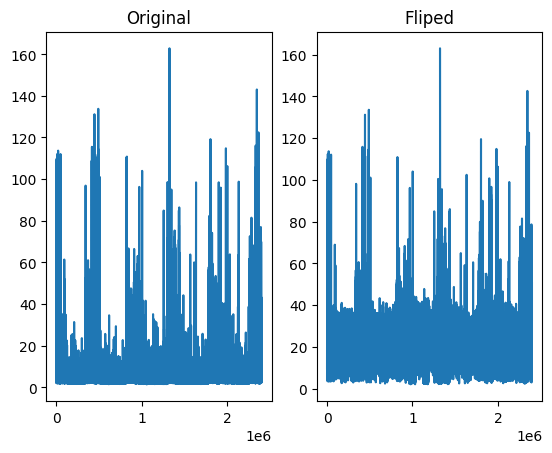

In [ ]:
plt.subplot(1,2,1)
plt.title("Original")
plt.plot(mcpjp[:,0])
plt.subplot(1,2,2)
plt.title("Fliped")
plt.plot(mcpjp[:,1])
plt.show()

In [ ]:
t_dist = 20
anomaly = dists > t_dist


# 거리가 t_dist를 넘은 좌표의 수
anomaly_summation = np.sum(anomaly,1) # n, 24, 2 -> n, 2

max_dists = np.max(dists,1)
max_idx = np.argmax(dists,1)

print(anomaly.shape,anomaly_summation.shape)

for t_count in range(25):
    print(f"t_count = { t_count } \t ( {np.sum(anomaly_summation[:,0]==t_count)} / {len(anomaly_summation)} ) \t {np.sum(anomaly_summation[:,0]==t_count)/len(anomaly_summation)*100}%, \t t_count >= { t_count } \t ( {np.sum(anomaly_summation[:,0]>=t_count)} / {len(anomaly_summation)} ) \t {np.sum(anomaly_summation[:,0]>=t_count)/len(anomaly_summation)*100}%")

(2398615, 24, 2) (2398615, 2)
t_count = 0 	 ( 2057448 / 2398615 ) 	 85.77650018865053%, 	 t_count >= 0 	 ( 2398615 / 2398615 ) 	 100.0%
t_count = 1 	 ( 90357 / 2398615 ) 	 3.7670489011366977%, 	 t_count >= 1 	 ( 341167 / 2398615 ) 	 14.223499811349466%
t_count = 2 	 ( 74953 / 2398615 ) 	 3.1248449626138415%, 	 t_count >= 2 	 ( 250810 / 2398615 ) 	 10.456450910212768%
t_count = 3 	 ( 54598 / 2398615 ) 	 2.2762302412016937%, 	 t_count >= 3 	 ( 175857 / 2398615 ) 	 7.331605947598926%
t_count = 4 	 ( 38716 / 2398615 ) 	 1.6140981357992006%, 	 t_count >= 4 	 ( 121259 / 2398615 ) 	 5.055375706397233%
t_count = 5 	 ( 26539 / 2398615 ) 	 1.1064301690767382%, 	 t_count >= 5 	 ( 82543 / 2398615 ) 	 3.4412775705980327%
t_count = 6 	 ( 20275 / 2398615 ) 	 0.845279463356979%, 	 t_count >= 6 	 ( 56004 / 2398615 ) 	 2.3348474015212948%
t_count = 7 	 ( 11761 / 2398615 ) 	 0.4903246248355822%, 	 t_count >= 7 	 ( 35729 / 2398615 ) 	 1.4895679381643157%
t_count = 8 	 ( 8265 / 2398615 ) 	 0.34457384782468

In [ ]:

start_idx = 0
indexing = (6 <= anomaly_summation[:,0]) & (anomaly_summation[:,0]<7)
length = len(idx_list[:len(indexing)][indexing])
for idx in tqdm.tqdm(idx_list[:len(indexing)][indexing][start_idx:start_idx+200]):
    i = idx[-1]

    print('\n',anomaly_summation[i,0],point_name[max_idx[i,0]],max_dists[i,0],i,length)


    data = train_set[i]
    img = (denormalization(data['image'].permute(1,2,0).numpy())*255).astype(np.uint8())

    plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    # 뒤에서 본 신체의 좌표
    plt.title("Left,Center,Right")
    plt.imshow(body_coord_visualization)

    plt.subplot(1,3,2)
    plt.title("True")
    plt.imshow(draw_joint(img,data['coord'],rad=2))

    plt.subplot(1,3,3)
    plt.title("pred")
    plt.imshow(draw_joint(img,torch.from_numpy(outputs[i]),rad=2))
    plt.show()

In [ ]:
#문제가 되는 영상 개수 파악
visit = [[],[],[],[],[]]
for i in range(5):
    for j in range(len(valid[i])):
        visit[i].append(False)
count= 0
for i in tqdm.tqdm(range(len(normal_anomaly))):
    if (normal_anomaly[i]):
        view,data,frame = idx_list[i]
        if (visit[view][data]==False):
            count += 1
            visit[view][data] = True
print()
print(f"{5*len(visit[0])}개 영상 중 문제가 되는 영상 {count}개")

# 모델별 신경망기반 이상치 탐지

In [ ]:
def MPJPE_heatmap(pred,true,image_size=[IMAGE_WIDTH,IMAGE_HEIGHT],mean=True): #Mean Per Joint Position Error ( 낮은게 좋음 )
    with torch.no_grad():
        b,c,h,w = pred.shape

        pred = pred.reshape(b,c,h*w)

        pred_flatten_idx = torch.argmax(pred,-1).reshape(b,c,1) # heatmap에서 제일 큰 값이 있는 index
        pred_xy = torch.cat([pred_flatten_idx%w/w,pred_flatten_idx//w/h],-1) # b, 24, 2 [x,y]

        wh = torch.tensor(image_size,dtype=torch.float32,device=pred.device)

        dist = torch.sqrt(torch.sum(((pred_xy-true)* wh)**2,-1)+1e-5) #b,24

        if mean :
            metric = torch.sum(dist)/(b*c) #1
        else :
            metric = torch.sum(dist,1)/c #b

    return metric, pred_xy, dist

def get_xy(heatmap):
    if (len(heatmap.shape)==4):
        b,c,h,w = heatmap.shape
        dim = 2
    else :
        c,h,w = heatmap.shape
        dim = 1

    heatmap_f = torch.flatten(heatmap,dim)
    heatmap_f = torch.argmax(heatmap_f,dim)
    xy = torch.stack([heatmap_f%w/w,heatmap_f//w/h],dim)
    return xy

In [ ]:
for i in range(1):
    #model_path = f'/content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model{i+1}]/'
    model_path = f'/content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1]/'
    print(model_path)
    model = ViTpose(backbone='b',mode='heatmap')
    checkpoint = torch.load(f'{model_path}Last5.pth','cuda')
    model.to(device)

    model.load_state_dict(checkpoint['model'],strict=False)
    split_data = []
    for inner_list in dataset:
        split_data.append([data for k,data in enumerate(inner_list) if k % 5 == i])

    outputs = []
    model.eval()
    split_set = fitness(split_data, views = [1,2,3,4,5], training =  False,frame_mode=2)

    train_loader = DataLoader(split_set,batch_size=128,shuffle=False, num_workers=4)
    with torch.no_grad():
        progress = tqdm.tqdm(train_loader,desc=f'MCPJP:')
        for data in progress:
            img = data['image'].to(device)

            pred = model(img,data['view'].to(device))['heatmap'] #b,c,h,w
            pts = get_xy(pred).detach().cpu().numpy() # b,24,2
            for j in range(len(pts)):
                outputs.append(pts[j])
    outputs= np.array(outputs)
    np.save(f'{model_path}valid',outputs)

/content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1]/


MCPJP:: 100%|██████████| 4526/4526 [3:10:15<00:00,  2.52s/it]


In [ ]:
sorted_data = [[],[],[],[],[]]
model_num = 0
model_path = f'/content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model{model_num+1},no_anomaly]/'
outputs = np.load(f'{model_path}valid.npy')
for j,inner_list in enumerate(dataset):
    sorted_data[j] += [data for k,data in enumerate(inner_list) if k % 5 == model_num]
sorted_set = fitness(sorted_data, views = [1,2,3,4,5], training =  False,frame_mode=2)
print(len(sorted_data[0]))
print(len(sorted_set))


7258
579290


In [ ]:
idx_list = []
wh = [IMAGE_WIDTH,IMAGE_HEIGHT]
mcpjp = [] # original
dists = [] # original
count = 0
for i in range(len(sorted_data)):
    for j in range(len(sorted_data[i])):
        for k in range(len(sorted_data[i][j][2])):

            idx_list.append([i,j,k,count])
            count += 1

idx_list = np.array(idx_list)

progress = tqdm.tqdm(range(len(outputs)))
sum_mcpjp = 0
for i in progress:
    view,data,frame,count = idx_list[i]

    x1,y1,x2,y2 = sorted_data[view][data][1]

    #사전에 미리 Crop한 이미지 x1,y1,x2,y2
    crop_min_x = max(0,x1-200)
    crop_min_y = max(0,y1-200)
    crop_max_x = min(1920,x2+200)
    crop_max_y = min(1080,y2+200)

    true = (np.array(sorted_data[view][data][2][frame]) - [crop_min_x,crop_min_y])/[crop_max_x-crop_min_x,crop_max_y-crop_min_y]

    pred = outputs[i]

    dist = np.sqrt(np.sum(((true-pred)*wh)**2,-1)+1e-5) # 24

    dists.append(dist)
    mcpjp.append(np.mean(dist))
    #sum_mcpjp += mcpjp[-2]
    #progress.set_description(f'{sum_mcpjp/(i+1)}')

dists = np.array(dists) # n,24
mcpjp = np.array(mcpjp) # n

100%|██████████| 579290/579290 [00:32<00:00, 17703.88it/s]


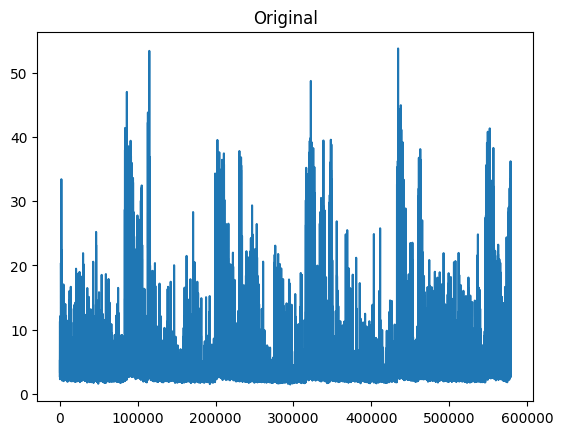

In [ ]:

plt.title("Original")
plt.plot(mcpjp)
plt.show()

In [ ]:
#no_anomaly
t_dist = 16
anomaly = dists > t_dist

# 거리가 t_dist를 넘은 좌표의 수 구하기
anomaly_summation = np.sum(anomaly,1) # n, 24 -> n

max_dists = np.max(dists,1)
max_idx = np.argmax(dists,1)

print(anomaly.shape,anomaly_summation.shape)

for t_count in range(25):
    print(f"t_count = { t_count } \t ( {np.sum(anomaly_summation==t_count)} / {len(anomaly_summation)} ) \t {np.sum(anomaly_summation==t_count)/len(anomaly_summation)*100}%, \t t_count >= { t_count } \t ( {np.sum(anomaly_summation>=t_count)} / {len(anomaly_summation)} ) \t {np.sum(anomaly_summation>=t_count)/len(anomaly_summation)*100}%")

(579290, 24) (579290,)
t_count = 0 	 ( 497032 / 579290 ) 	 85.80020369762987%, 	 t_count >= 0 	 ( 579290 / 579290 ) 	 100.0%
t_count = 1 	 ( 23984 / 579290 ) 	 4.140240639403408%, 	 t_count >= 1 	 ( 82258 / 579290 ) 	 14.199796302370144%
t_count = 2 	 ( 18360 / 579290 ) 	 3.1693970204906003%, 	 t_count >= 2 	 ( 58274 / 579290 ) 	 10.059555662966735%
t_count = 3 	 ( 13620 / 579290 ) 	 2.351153998860674%, 	 t_count >= 3 	 ( 39914 / 579290 ) 	 6.890158642476135%
t_count = 4 	 ( 9571 / 579290 ) 	 1.6521949282742667%, 	 t_count >= 4 	 ( 26294 / 579290 ) 	 4.53900464361546%
t_count = 5 	 ( 6606 / 579290 ) 	 1.1403614769804415%, 	 t_count >= 5 	 ( 16723 / 579290 ) 	 2.8868097153411933%
t_count = 6 	 ( 4808 / 579290 ) 	 0.8299815291132249%, 	 t_count >= 6 	 ( 10117 / 579290 ) 	 1.746448238360752%
t_count = 7 	 ( 2619 / 579290 ) 	 0.4521051632170416%, 	 t_count >= 7 	 ( 5309 / 579290 ) 	 0.9164667092475272%
t_count = 8 	 ( 1896 / 579290 ) 	 0.32729720865197054%, 	 t_count >= 8 	 ( 2690 / 579290

In [ ]:
t_dist = 16
anomaly = dists > t_dist

# 거리가 t_dist를 넘은 좌표의 수 구하기
anomaly_summation = np.sum(anomaly,1) # n, 24 -> n

max_dists = np.max(dists,1)
max_idx = np.argmax(dists,1)

print(anomaly.shape,anomaly_summation.shape)

for t_count in range(25):
    print(f"t_count = { t_count } \t ( {np.sum(anomaly_summation==t_count)} / {len(anomaly_summation)} ) \t {np.sum(anomaly_summation==t_count)/len(anomaly_summation)*100}%, \t t_count >= { t_count } \t ( {np.sum(anomaly_summation>=t_count)} / {len(anomaly_summation)} ) \t {np.sum(anomaly_summation>=t_count)/len(anomaly_summation)*100}%")

(579290, 24) (579290,)
t_count = 0 	 ( 495889 / 579290 ) 	 85.6028931968444%, 	 t_count >= 0 	 ( 579290 / 579290 ) 	 100.0%
t_count = 1 	 ( 23610 / 579290 ) 	 4.075678848245266%, 	 t_count >= 1 	 ( 83401 / 579290 ) 	 14.397106803155587%
t_count = 2 	 ( 18382 / 579290 ) 	 3.173194772911668%, 	 t_count >= 2 	 ( 59791 / 579290 ) 	 10.321427954910321%
t_count = 3 	 ( 13225 / 579290 ) 	 2.282967080391514%, 	 t_count >= 3 	 ( 41409 / 579290 ) 	 7.148233181998654%
t_count = 4 	 ( 9376 / 579290 ) 	 1.618533031814808%, 	 t_count >= 4 	 ( 28184 / 579290 ) 	 4.86526610160714%
t_count = 5 	 ( 6793 / 579290 ) 	 1.1726423725595125%, 	 t_count >= 5 	 ( 18808 / 579290 ) 	 3.246733069792332%
t_count = 6 	 ( 5504 / 579290 ) 	 0.9501286057069862%, 	 t_count >= 6 	 ( 12015 / 579290 ) 	 2.0740906972328195%
t_count = 7 	 ( 3144 / 579290 ) 	 0.5427333459925081%, 	 t_count >= 7 	 ( 6511 / 579290 ) 	 1.1239620915258333%
t_count = 8 	 ( 2108 / 579290 ) 	 0.3638937319822541%, 	 t_count >= 8 	 ( 3367 / 579290 ) 	

In [ ]:

labels = {model_num:{}}
indexing = (10 <= anomaly_summation) & (anomaly_summation<25)
for iter,idx in enumerate(tqdm.tqdm(idx_list[:len(indexing)][indexing])):
    i = idx[-1]
    data = sorted_set[i]
    view_idx,data_idx,frame_idx = data['idx']
    filename = sorted_data[view_idx][data_idx][0]
    label_name = sorted_data[view_idx][data_idx][-1]


    if (labels[model_num].get(filename) is None):
        labels[model_num][filename] = {"class": data["class"],"label":label_name,"frame":[frame_idx]}
    else:
        labels[model_num][filename]["frame"].append(frame_idx)


with open(f"/content/drive/MyDrive/fitness/dataset/anomaly/{model_num}.json",'w') as f:
    json.dump(labels,f)


In [ ]:
print(len(labels.keys()))
labels

In [ ]:
# no_anomaly
start_idx = 0
indexing = (10 <= anomaly_summation) & (anomaly_summation<25)
length = len(idx_list[:len(indexing)][indexing])
for idx in tqdm.tqdm(idx_list[:len(indexing)][indexing][start_idx:start_idx+200]):
    i = idx[-1]

    print('\n',anomaly_summation[i],point_name[max_idx[i]],max_dists[i],i,length)


    data = sorted_set[i]
    img = (denormalization(data['image'].permute(1,2,0).numpy())*255).astype(np.uint8())

    plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    # 뒤에서 본 신체의 좌표
    plt.title("Left,Center,Right")
    plt.imshow(body_coord_visualization)

    plt.subplot(1,3,2)
    plt.title("True")
    plt.imshow(draw_joint(img,data['coord'],rad=2))

    plt.subplot(1,3,3)
    plt.title("pred")
    plt.imshow(draw_joint(img,torch.from_numpy(outputs[i]),rad=2))
    plt.show()

In [ ]:
# anomaly
start_idx = 0
indexing = (10 <= anomaly_summation) & (anomaly_summation<25)
length = len(idx_list[:len(indexing)][indexing])
for idx in tqdm.tqdm(idx_list[:len(indexing)][indexing][start_idx:start_idx+200]):
    i = idx[-1]

    print('\n',anomaly_summation[i],point_name[max_idx[i]],max_dists[i],i,length)


    data = sorted_set[i]
    img = (denormalization(data['image'].permute(1,2,0).numpy())*255).astype(np.uint8())

    plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    # 뒤에서 본 신체의 좌표
    plt.title("Left,Center,Right")
    plt.imshow(body_coord_visualization)

    plt.subplot(1,3,2)
    plt.title("True")
    plt.imshow(draw_joint(img,data['coord'],rad=2))

    plt.subplot(1,3,3)
    plt.title("pred")
    plt.imshow(draw_joint(img,torch.from_numpy(outputs[i]),rad=2))
    plt.show()

In [ ]:
for model_num in range(5):
    sorted_data = [[],[],[],[],[]]
    model_path = f'/content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model{model_num+1}]/'
    outputs = np.load(f'{model_path}valid.npy')
    for j,inner_list in enumerate(dataset):
        sorted_data[j] += [data for k,data in enumerate(inner_list) if k % 5 == model_num]
    sorted_set = fitness(sorted_data, views = [1,2,3,4,5], training =  False,frame_mode=2)
    print(model_num)
    print(len(sorted_data[0]))
    print(len(sorted_set))
    idx_list = []
    wh = [IMAGE_WIDTH,IMAGE_HEIGHT]
    mcpjp = [] # original
    dists = [] # original
    count = 0
    for i in range(len(sorted_data)):
        for j in range(len(sorted_data[i])):
            for k in range(len(sorted_data[i][j][2])):

                idx_list.append([i,j,k,count])
                count += 1

    idx_list = np.array(idx_list)

    progress = tqdm.tqdm(range(len(outputs)))
    sum_mcpjp = 0
    for i in progress:
        view,data,frame,count = idx_list[i]

        x1,y1,x2,y2 = sorted_data[view][data][1]

        #사전에 미리 Crop한 이미지 x1,y1,x2,y2
        crop_min_x = max(0,x1-200)
        crop_min_y = max(0,y1-200)
        crop_max_x = min(1920,x2+200)
        crop_max_y = min(1080,y2+200)

        true = (np.array(sorted_data[view][data][2][frame]) - [crop_min_x,crop_min_y])/[crop_max_x-crop_min_x,crop_max_y-crop_min_y]

        pred = outputs[i]

        dist = np.sqrt(np.sum(((true-pred)*wh)**2,-1)+1e-5) # 24

        dists.append(dist)
        mcpjp.append(np.mean(dist))
        #sum_mcpjp += mcpjp[-2]
        #progress.set_description(f'{sum_mcpjp/(i+1)}')

    dists = np.array(dists) # n,24
    mcpjp = np.array(mcpjp) # n
    t_dist = 16
    anomaly = dists > t_dist

    # 거리가 t_dist를 넘은 좌표의 수 구하기
    anomaly_summation = np.sum(anomaly,1) # n, 24 -> n

    max_dists = np.max(dists,1)
    max_idx = np.argmax(dists,1)

    print(anomaly.shape,anomaly_summation.shape)

    labels = {model_num:{}}
    indexing = (10 <= anomaly_summation) & (anomaly_summation<25)
    for iter,idx in enumerate(tqdm.tqdm(idx_list[:len(indexing)][indexing])):
        i = idx[-1]
        data = sorted_set[i]
        view_idx,data_idx,frame_idx = data['idx']
        filename = sorted_data[view_idx][data_idx][0]
        label_name = sorted_data[view_idx][data_idx][-1]


        if (labels[model_num].get(filename) is None):
            labels[model_num][filename] = {"class": data["class"],"label":label_name,"frame":[frame_idx]}
        else:
            labels[model_num][filename]["frame"].append(frame_idx)


    with open(f"/content/drive/MyDrive/fitness/dataset/anomaly/{model_num}.json",'w') as f:
        json.dump(labels,f)


#추론


In [26]:
model = ViTpose(backbone='b',mode='heatmap')
checkpoint = torch.load('/content/drive/MyDrive/fitness/model/PE/ViTPose_base_simple(heatmap)[model1,no_anomaly]/Best10.pth','cuda')
model.to(device)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [25]:
def get_xy(heatmap):
    heatmap = heatmap.detach().clone()
    c,h,w = heatmap.shape
    heatmap_f = torch.flatten(heatmap,1)
    heatmap_f = torch.argmax(heatmap_f,1)
    xy = torch.stack([heatmap_f%w/w,heatmap_f//w/h],1)
    return xy


In [ ]:

cap = cv2.VideoCapture("/content/drive/MyDrive/fitness/test/덤벨컬 (1).mp4")
while True:
    # 비디오에서 프레임 읽기
    ret, img = cap.read()
    if ret == False:
        break

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
    img = A.Compose([A.Normalize(),ToTensorV2()])(image=img)['image']
    img = img.unsqueeze(0).to(device)
    pred = model(img)['heatmap']

    img = img[0].detach().cpu()
    img = (denormalization(img.permute(1,2,0).numpy())*255).astype(np.uint8())
    pred = pred[0].detach().cpu()
    h,w,c = img.shape

    pts = get_xy(pred).detach().cpu().numpy() * [w,h]

    plt.figure(figsize=(15,15))

    pred = pred.numpy()
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(draw_joint(img,torch.from_numpy(pts)))
    plt.subplot(1,3,3)
    plt.imshow(np.sum(pred,0))
    plt.show()

cap.release()
cv2.destroyAllWindows()